In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# KFold = regression, StratifiedKFold = classification (preserve output class proportions)
from sklearn.model_selection import RepeatedKFold, KFold, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, HDBSCAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
co2 = pd.read_csv("CO2_Dataset/CO2_Emissions_Canada.csv")

In [3]:
rename = {
    "Make" : "make",
    "Model" : "model",
    "Vehicle Class": "vehicle_class",
    "Engine Size(L)": "engine_size",
    "Cylinders": "cylinders",
    "Transmission" : "transmission",
    "Fuel Type": "fuel_type",
    "Fuel Consumption City (L/100 km)": "fuel_cons_city",
    "Fuel Consumption Hwy (L/100 km)": "fuel_cons_hwy",
    "Fuel Consumption Comb (L/100 km)": "fuel_cons_comb",
    "Fuel Consumption Comb (mpg)": "fuel_cons_comb_mpg",
    "CO2 Emissions(g/km)": "co2" }
co2.rename(rename, axis="columns", inplace=True)

### One-hot encoding

In [4]:
co2_prep = co2.drop(columns=["make", "model", "fuel_cons_city", "fuel_cons_hwy"])

X_num = co2_prep.select_dtypes(exclude='object')
X_cat = co2_prep.select_dtypes(include='object')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_cat)
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in encoder.categories_[i]]
one_hot_features = pd.DataFrame(X_encoded, columns=categorical_columns)
co2_enc = X_num.join(one_hot_features)

In [5]:
y = co2_enc["co2"]
X = co2_enc.drop(columns="co2")
X.head()

,engine_size,cylinders,fuel_cons_comb,fuel_cons_comb_mpg,vehicle_class_COMPACT,vehicle_class_FULL-SIZE,vehicle_class_MID-SIZE,vehicle_class_MINICOMPACT,vehicle_class_MINIVAN,vehicle_class_PICKUP TRUCK - SMALL,...,transmission_AV7,transmission_AV8,transmission_M5,transmission_M6,transmission_M7,fuel_type_D,fuel_type_E,fuel_type_N,fuel_type_X,fuel_type_Z
0,2.0,4,8.5,33,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.4,4,9.6,29,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.5,4,5.9,48,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.5,6,11.1,25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.5,6,10.6,27,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Mean emissions per feature

In [6]:
def plot_mean_feat(feat):
    
    feat_group = co2.groupby(feat)
    co2_feat = feat_group["co2"].mean()
    
    fig = plt.figure(figsize=[15,7])
    co2_feat.sort_values().plot(kind = "bar", fontsize = 10)
    plt.ylabel("CO$_{2}$ emissions")
    plt.show()
    
    return

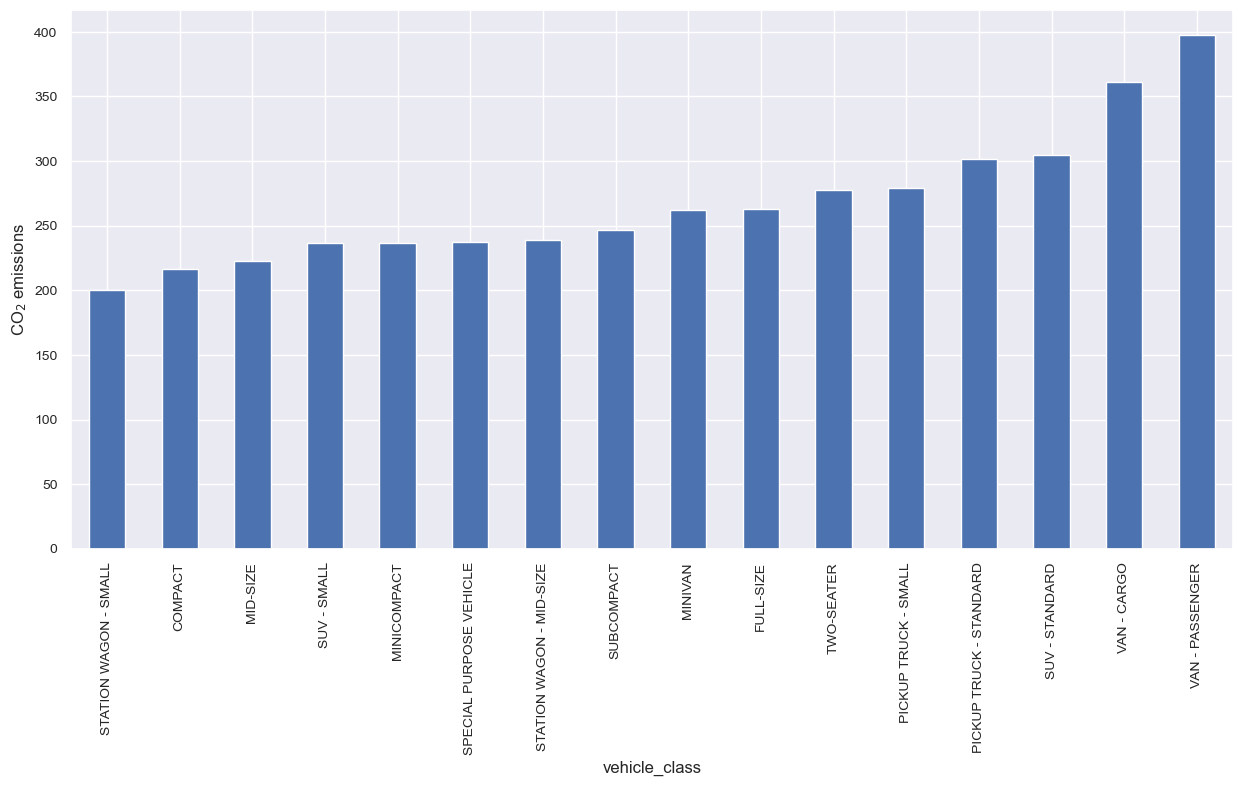

In [7]:
plot_mean_feat("vehicle_class")

### Predicting if high emissions

In [8]:
co2["high"] = co2["co2"] > 255
co2_enc["high"] = co2_enc["co2"] > 255

In [9]:
co2["high"] = co2["high"].astype(int) # Convert to 1s and 0s
co2_enc["high"] = co2_enc["high"].astype(int)

In [10]:
co2.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,fuel_cons_comb_mpg,co2,high
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196,0
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221,0
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136,0
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,0
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,0


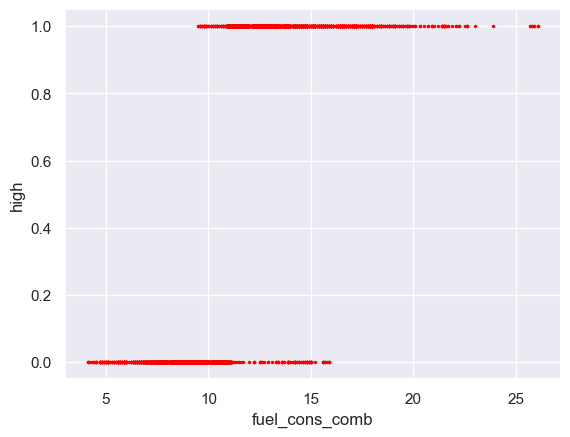

In [11]:
axis = co2.plot.scatter(x="fuel_cons_comb", y="high", c="red", s=2)

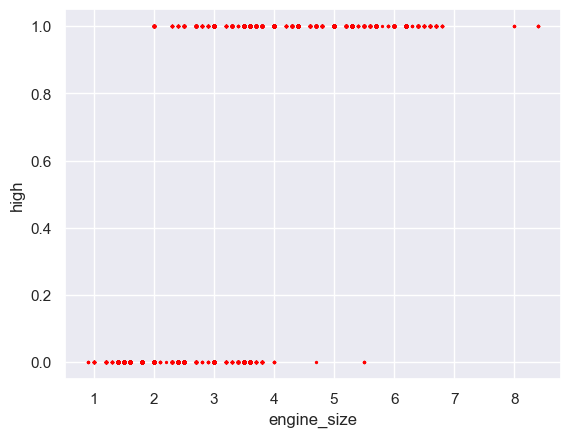

In [12]:
axis = co2.plot.scatter(x="engine_size", y="high", c="red", s=2)

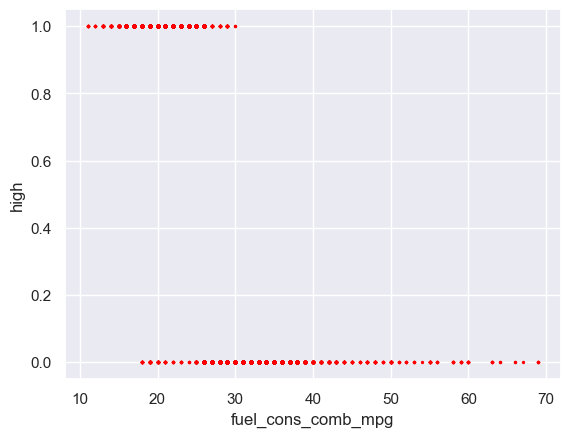

In [13]:
axis = co2.plot.scatter(x="fuel_cons_comb_mpg", y="high", c="red", s=2)

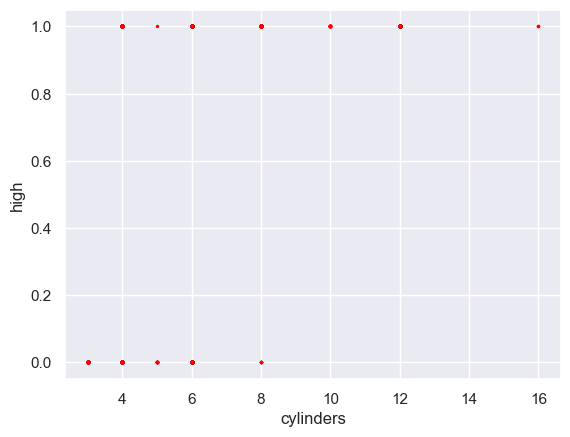

In [14]:
axis = co2.plot.scatter(x="cylinders", y="high", c="red", s=2)

In [15]:
def cm_metrics(cm):
    
    TP = cm[0][0]
    FP = cm[0][1]
    TN = cm[1][1]
    FN = cm[1][0]

    total = TP + FP + TN + FN
    accuracy = (TP+TN) / total
    print("Accuracy: ", accuracy.round(4))
    
    prec = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1 = 2 * ((prec*recall) / (prec+recall))
    print("Precision: ", prec.round(4))
    print("Recall: ", recall.round(4))
    print("F1: ", f1.round(4))
    
    return

In [16]:
def plot_cm_logistic(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

    logistic_regression = LogisticRegression(max_iter=1000)
    logistic_regression.fit(X_train, y_train)

    y_pred = logistic_regression.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = "Blues")
    plt.grid(False)
    plt.show()

    cm_metrics(cm)

    #print(metrics.classification_report(y_test, y_pred))

    #mean_acc = logistic_regression.score(X_test, y_test)
    #print("Accuracy:", mean_acc)
    
    return

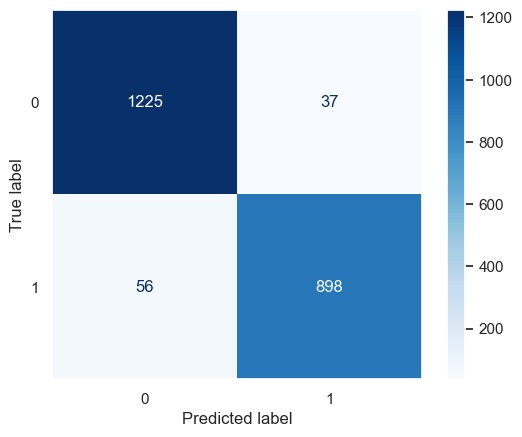

Accuracy:  0.958
Precision:  0.9707
Recall:  0.9563
F1:  0.9634


In [17]:
X = co2[["fuel_cons_comb"]]
y = co2["high"]

plot_cm_logistic(X, y)

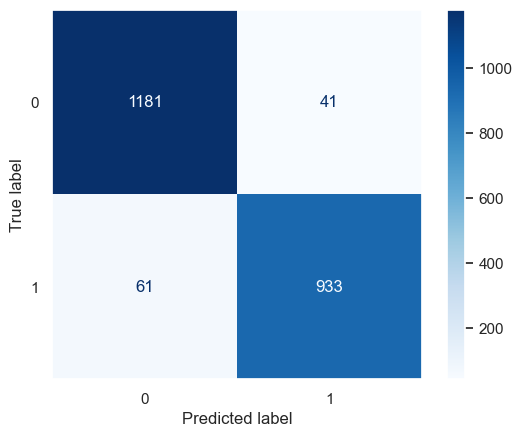

Accuracy:  0.954
Precision:  0.9664
Recall:  0.9509
F1:  0.9586


In [18]:
X = co2[["fuel_cons_comb_mpg"]]
y = co2["high"]

plot_cm_logistic(X, y)

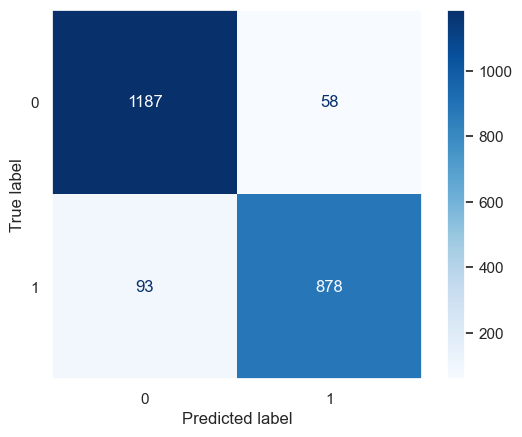

Accuracy:  0.9319
Precision:  0.9534
Recall:  0.9273
F1:  0.9402


In [19]:
X = co2[["fuel_cons_comb", "engine_size"]]
y = co2["high"]

plot_cm_logistic(X, y)

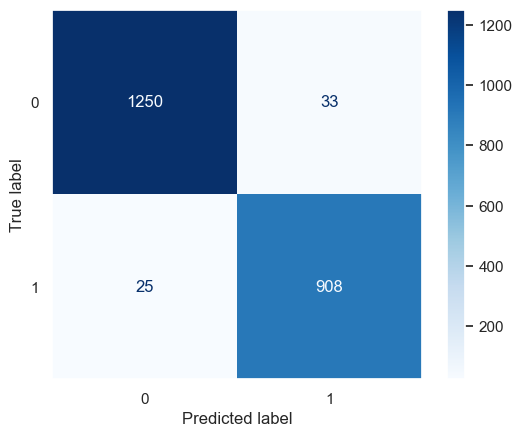

Accuracy:  0.9738
Precision:  0.9743
Recall:  0.9804
F1:  0.9773


In [20]:
X = co2_enc.drop(columns=["co2", "high", "fuel_cons_comb_mpg", "engine_size"])
y = co2_enc["high"]

plot_cm_logistic(X, y)

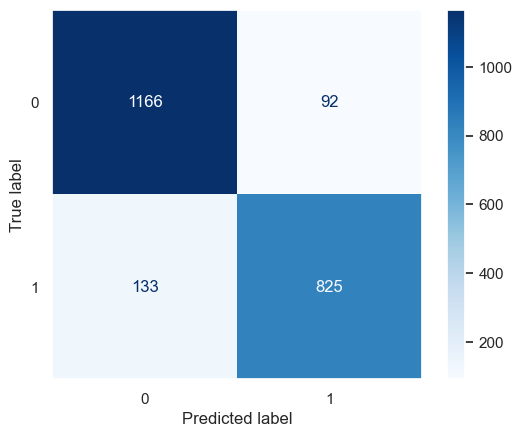

Accuracy:  0.8985
Precision:  0.9269
Recall:  0.8976
F1:  0.912


In [21]:
X = co2_enc.drop(columns=["co2", "high", "fuel_cons_comb_mpg", "fuel_cons_comb"])
y = co2_enc["high"]

plot_cm_logistic(X, y)

## Stratified K-Fold Cross Validation

In [22]:
X = co2[["fuel_cons_comb"]]
y = co2["high"]

model = LogisticRegression()
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=11)
splits = kfold.split(X,y)

acc = cross_val_score(model, X, y, scoring="accuracy", cv=splits, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(acc), np.std(acc)))

Accuracy: 0.954 (0.006)


In [23]:
X = co2[["fuel_cons_comb", "engine_size", "cylinders"]]
y = co2["high"]

model = LogisticRegression()
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=11)
splits = kfold.split(X,y)

acc = cross_val_score(model, X, y, scoring="accuracy", cv=splits, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(acc), np.std(acc)))

Accuracy: 0.945 (0.005)


In [24]:
X = co2[["fuel_cons_comb"]]
y = co2["high"]

model = LogisticRegression()
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=11)
splits = kfold.split(X,y)

f1 = cross_val_score(model, X, y, scoring="f1", cv=splits, n_jobs=-1)
print('F1: %.3f (%.3f)' % (np.mean(f1), np.std(f1)))

F1: 0.946 (0.008)


## Clustering

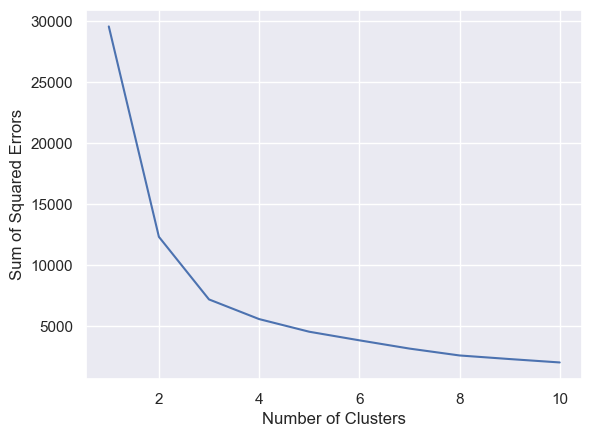

In [25]:
X = co2[["engine_size", "cylinders", "fuel_cons_comb", "fuel_cons_comb_mpg"]]
y = co2["co2"]
co2_cluster = pd.concat([X, y], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sse = [] # elbow method
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=1, n_init=10)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(range(1,11), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.show()

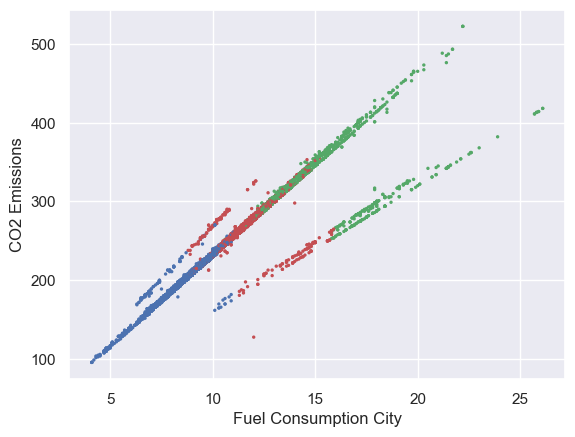

In [26]:
km = KMeans(n_clusters=3, random_state=1, n_init=10)
km.fit(X_scaled)
clusters = km.labels_

label_colour_map = {0 : "r", 
                    1 : "b",
                    2 : "g"}

label_colour = [label_colour_map[c] for c in clusters]

co2_cluster["cluster"] = clusters
co2_cluster.groupby("cluster").mean()

#plt.scatter(co2_cluster["fuel_cons_comb"], co2_cluster["co2"], c=co2_cluster["cluster"], s=2)
plt.scatter(co2_cluster["fuel_cons_comb"], co2_cluster["co2"], c=label_colour, s=2)
plt.xlabel("Fuel Consumption City")
plt.ylabel("CO2 Emissions")
plt.show()

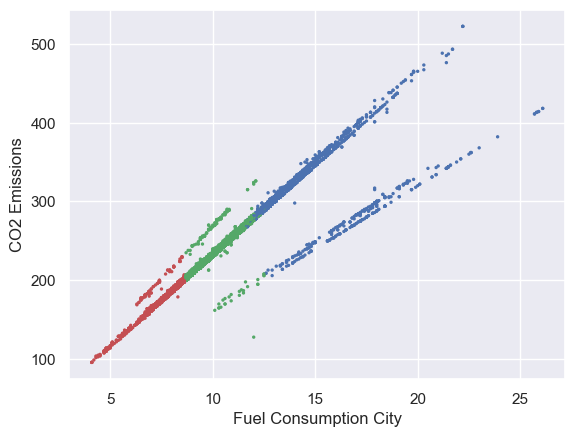

In [27]:
X = co2[["engine_size", "cylinders", "fuel_cons_comb", "fuel_cons_comb_mpg"]]
y = co2["co2"]
co2_cluster = pd.concat([X, y], axis=1)

km = KMeans(n_clusters=3, random_state=1, n_init=10)
km.fit(X)
clusters = km.labels_

label_colour_map = {0 : "r", 
                    1 : "b",
                    2 : "g"}

label_colour = [label_colour_map[c] for c in clusters]

co2_cluster["cluster"] = clusters
co2_cluster.groupby("cluster").mean()

plt.scatter(co2_cluster["fuel_cons_comb"], co2_cluster["co2"], c=label_colour, s=2)
plt.xlabel("Fuel Consumption City")
plt.ylabel("CO2 Emissions")
plt.show()

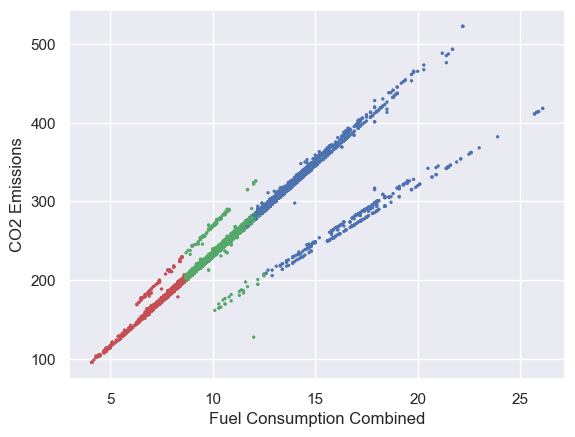

In [28]:
co2_cluster.groupby("cluster").mean()

plt.scatter(co2_cluster["fuel_cons_comb"], co2_cluster["co2"], c=label_colour, s=2)
plt.xlabel("Fuel Consumption Combined")
plt.ylabel("CO2 Emissions")
plt.show()

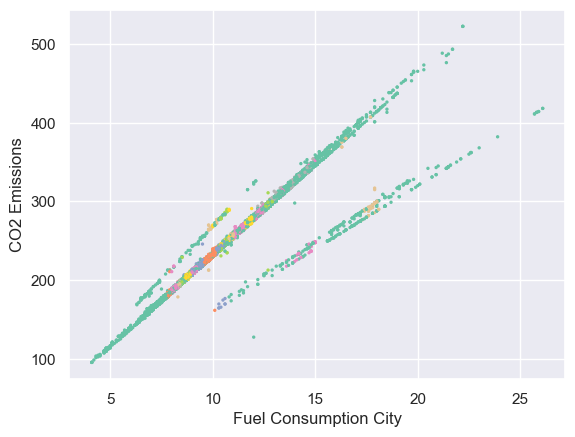

In [29]:
X = co2[["engine_size", "cylinders", "fuel_cons_comb", "fuel_cons_comb_mpg"]]
y = co2["co2"]
co2_cluster = pd.concat([X, y], axis=1)

db = HDBSCAN(alpha=3, min_samples=30).fit(X)
clusters = db.labels_

co2_cluster["cluster"] = clusters
co2_cluster.groupby("cluster").mean()

plt.scatter(co2_cluster["fuel_cons_comb"], co2_cluster["co2"], c=co2_cluster["cluster"], cmap="Set2", s=2)
plt.xlabel("Fuel Consumption City")
plt.ylabel("CO2 Emissions")
plt.show()